In [4]:
!pip install --upgrade requests urllib3
!pip install timm
!pip install -q transformers accelerate huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [20]:
# CLASSES NAMES

import os

# Datasets and their relevant directories
datasets = {
    "New Plant Diseases Dataset (Train)": "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
    "New Plant Diseases Dataset (Valid)": "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
    "PlantDoc Dataset (Train)": "/kaggle/input/plantdoc-dataset/train",
    "PlantDoc Dataset (Test)": "/kaggle/input/plantdoc-dataset/test"
}


def count_images_per_class(dir_path):
    """Return a dict: {class_name: image_count}"""
    if not os.path.exists(dir_path):
        return None, f"Directory not found: {dir_path}"

    counts = {}
    for cls in sorted(os.listdir(dir_path)):
        cls_path = os.path.join(dir_path, cls)
        if os.path.isdir(cls_path):
            num_images = sum(
                len(files) for _, _, files in os.walk(cls_path)
                if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in files)
            )
            counts[cls] = num_images
    return counts, None

# ---- MAIN ----
for dataset_name, path in datasets.items():
    print(f"\n📂 Dataset: {dataset_name}")
    print(f"   Path: {path}")

    counts, err = count_images_per_class(path)
    if err:
        print(f"❌ {err}")
        continue

    total = sum(counts.values())
    print(f"   ➤ Total Images: {total}")
    print("   ➤ Class-wise Counts:")
    for cls, count in counts.items():
        print(f"     - {cls}: {count}")



📂 Dataset: New Plant Diseases Dataset (Train)
   Path: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
   ➤ Total Images: 70295
   ➤ Class-wise Counts:
     - Apple___Apple_scab: 2016
     - Apple___Black_rot: 1987
     - Apple___Cedar_apple_rust: 1760
     - Apple___healthy: 2008
     - Blueberry___healthy: 1816
     - Cherry_(including_sour)___Powdery_mildew: 1683
     - Cherry_(including_sour)___healthy: 1826
     - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642
     - Corn_(maize)___Common_rust_: 1907
     - Corn_(maize)___Northern_Leaf_Blight: 1908
     - Corn_(maize)___healthy: 1859
     - Grape___Black_rot: 1888
     - Grape___Esca_(Black_Measles): 1920
     - Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722
     - Grape___healthy: 1692
     - Orange___Haunglongbing_(Citrus_greening): 2010
     - Peach___Bacterial_spot: 1838
     - Peach___healthy: 1728
     - Pepper,_bell___Bacterial_spot: 191

In [21]:
import os
import shutil
from collections import defaultdict
import albumentations as A
import cv2
from tqdm import tqdm


# ============================================================
# 1️⃣ SOURCE DIRECTORIES
# ============================================================
source_dirs = [
    "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
    "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
    "/kaggle/input/plantdoc-dataset/train",  # PlantDoc train
    "/kaggle/input/plantdoc-dataset/test"    # PlantDoc test
]

# Output combined directory
combined_output_dir = "/kaggle/working/final_augmented_potato_tomato_dataset"
os.makedirs(combined_output_dir, exist_ok=True)


# ============================================================
# 2️⃣ CLASS MAPPING (Updated - Unified Naming for Combined + PlantDoc)
# ============================================================
class_mapping = {
    # ------------------ POTATO ------------------
    "Potato_Early_blight": "Potato Early Blight",
    "Potato_leaf_early_blight": "Potato Early Blight",
    "Potato_leaf_late_blight": "Potato Late Blight",
    "Potato_Late_blight": "Potato Late Blight",
    "Potato_healthy": "Potato Healthy",
    "Potato_leaf": "Potato Healthy",

    # ------------------ TOMATO ------------------
    "Tomato___Bacterial_spot": "Tomato Bacterial Spot",
    "Tomato_leaf_bacterial_spot": "Tomato Bacterial Spot",

    "Tomato___Early_blight": "Tomato Early Blight",
    "Tomato_Early_blight_leaf": "Tomato Early Blight",
    "Tomato_leaf_early_blight": "Tomato Early Blight",

    "Tomato___Late_blight": "Tomato Late Blight",
    "Tomato_leaf_late_blight": "Tomato Late Blight",

    "Tomato___Leaf_Mold": "Tomato Leaf Mold",
    "Tomato_mold_leaf": "Tomato Leaf Mold",

    "Tomato___Septoria_leaf_spot": "Tomato Septoria Leaf Spot",
    "Tomato_Septoria_leaf_spot": "Tomato Septoria Leaf Spot",

    "Tomato___Target_Spot": "Tomato Target Spot",

    "Tomato___Tomato_Yellow_Leaf_Curl_Virus": "Tomato Yellow Leaf Curl Virus",
    "Tomato_leaf_yellow_virus": "Tomato Yellow Leaf Curl Virus",

    "Tomato___Tomato_mosaic_virus": "Tomato Mosaic Virus",
    "Tomato_leaf_mosaic_virus": "Tomato Mosaic Virus",

    "Tomato___healthy": "Tomato Healthy",
    "Tomato_leaf": "Tomato Healthy",

    # ------------------ EXTRA (FOR SAFETY) ------------------
    "Tomato_two_spotted_spider_mites_leaf": "Tomato Spider Mites",
    "Tomato___Spider_mites_Two-spotted_spider_mite": "Tomato Spider Mites",
}



# ============================================================
# 3️⃣ AUGMENTATION PIPELINE
# ============================================================
augmentation_pipeline = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Transpose(p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.CLAHE(p=0.5),
])


def apply_augmentation_and_save(src_path, dst_path, apply_augment=False):
    img = cv2.imread(src_path)
    if img is None:
        print(f"Failed to read {src_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if apply_augment:
        augmented = augmentation_pipeline(image=img)
        img_aug = augmented['image']
        img_aug = cv2.cvtColor(img_aug, cv2.COLOR_RGB2BGR)
        if img_aug.dtype != 'uint8':
            img_aug = (img_aug * 255).clip(0, 255).astype('uint8')
        cv2.imwrite(dst_path, img_aug)
    else:
        shutil.copy2(src_path, dst_path)


# ============================================================
# 4️⃣ MERGE + AUGMENT LOGIC
# ============================================================
plantdoc_dirs = [
    "/kaggle/input/plantdoc-dataset/train",
    "/kaggle/input/plantdoc-dataset/test"
]

class_file_counters = defaultdict(int)

from tqdm import tqdm

# Process datasets with cleaner tqdm progress bars
for src_dir in tqdm(source_dirs, desc="Processing source directories", dynamic_ncols=True):
    if not os.path.exists(src_dir):
        print(f"Source directory not found: {src_dir}")
        continue

    is_plantdoc = any(src_dir.startswith(pd) for pd in plantdoc_dirs)
    class_names = [
        cl for cl in os.listdir(src_dir)
        if os.path.isdir(os.path.join(src_dir, cl)) and cl in class_mapping
    ]

    for class_name in tqdm(class_names, desc=f"Classes in {os.path.basename(src_dir)}", leave=False, dynamic_ncols=True):
        src_class_path = os.path.join(src_dir, class_name)
        normalized_class_name = class_mapping[class_name]
        dest_class_path = os.path.join(combined_output_dir, normalized_class_name)
        os.makedirs(dest_class_path, exist_ok=True)

        img_files = [
            f for f in os.listdir(src_class_path)
            if os.path.isfile(os.path.join(src_class_path, f))
        ]

        # Use tqdm with less frequent refresh and no line spam
        for img_file in tqdm(
            img_files,
            desc=f"Augmenting {class_name}",
            leave=False,
            dynamic_ncols=True,
            mininterval=1.0,  # updates once per second max
            position=2
        ):
            img_src_path = os.path.join(src_class_path, img_file)
            base, ext = os.path.splitext(img_file)
            count = class_file_counters[normalized_class_name]
            class_file_counters[normalized_class_name] += 1

            img_dest_path = os.path.join(dest_class_path, f"{base}_{count}{ext}")

            if is_plantdoc:
                # Save original
                shutil.copy2(img_src_path, img_dest_path)

                # Save augmented copies
                num_aug = 3
                for i in range(num_aug):
                    aug_filename = f"{base}_{count}_aug{i}{ext}"
                    aug_dest_path = os.path.join(dest_class_path, aug_filename)
                    apply_augmentation_and_save(img_src_path, aug_dest_path, apply_augment=True)

            else:
                shutil.copy2(img_src_path, img_dest_path)


print(f"\n✅ Final combined dataset (original + augmented) saved at:\n{combined_output_dir}")


# ============================================================
# 5️⃣ PRINT DATASET IMAGE COUNTS
# ============================================================
def count_images_in_dataset(dataset_path):
    counts = defaultdict(int)
    for cls in sorted(os.listdir(dataset_path)):
        cls_path = os.path.join(dataset_path, cls)
        if os.path.isdir(cls_path):
            num_imgs = sum(len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                           for _, _, files in os.walk(cls_path))
            counts[cls] = num_imgs
    return counts


print("\n=================== FINAL AUGMENTED DATASET COUNTS ===================")
final_counts = count_images_in_dataset(combined_output_dir)
final_total = sum(final_counts.values())
print(f"📊 Total images after merging and augmentation: {final_total}")
for cls, count in final_counts.items():
    print(f"   - {cls}: {count}")


Classes in train:   0%|          | 0/9 [00:00<?, ?it/s]

Augmenting Tomato___Late_blight:   0%|          | 0/1851 [00:00<?, ?it/s]

Augmenting Tomato___Late_blight:  13%|█▎        | 234/1851 [00:01<00:06, 233.57it/s]

Augmenting Tomato___Late_blight:  25%|██▌       | 468/1851 [00:02<00:06, 217.30it/s]

Augmenting Tomato___Late_blight:  38%|███▊      | 704/1851 [00:03<00:05, 225.17it/s]

Augmenting Tomato___Late_blight:  50%|█████     | 930/1851 [00:04<00:04, 216.94it/s]

Augmenting Tomato___Late_blight:  63%|██████▎   | 1169/1851 [00:05<00:03, 224.39it/s]

Augmenting Tomato___Late_blight:  75%|███████▌  | 1395/1851 [00:06<00:02, 220.16it/s]

Augmenting Tomato___Late_blight:  87%|████████▋ | 1616/1851 [00:07<00:01, 217.31it/s]

Augmenting Tomato___Late_blight: 100%|█████████▉| 1846/1851 [00:08<00:00, 221.11it/s]

                                                                                     
Classes in train:  11%|█         | 1/9 [00:09<01:14,  9.31s/it]

Augmenting Tomato___healt


✅ Final combined dataset (original + augmented) saved at:
/kaggle/working/final_augmented_potato_tomato_dataset

=================== FINAL AUGMENTED DATASET COUNTS ===================
📊 Total images after merging and augmentation: 52360
   - Potato Early Blight: 2465
   - Potato Healthy: 152
   - Potato Late Blight: 2759
   - Tomato Bacterial Spot: 5241
   - Tomato Early Blight: 4209
   - Tomato Healthy: 4507
   - Tomato Late Blight: 5211
   - Tomato Leaf Mold: 4141
   - Tomato Mosaic Virus: 3122
   - Tomato Septoria Leaf Spot: 5377
   - Tomato Spider Mites: 1692
   - Tomato Target Spot: 3706
   - Tomato Yellow Leaf Curl Virus: 9778


In [22]:
# ==============================================
# 📊 Dataset-wise and Class-wise Image Count Split (Generalized)
# ==============================================
import os
import pandas as pd
import re

# ✅ Final unified target classes
final_classes = [
    "Potato Early Blight",
    "Tomato Bacterial Spot",
    "Tomato Early Blight",
    "Tomato Healthy",
    "Tomato Late Blight",
    "Tomato Leaf Mold",
    "Tomato Mosaic Virus",
    "Tomato Septoria Leaf Spot",
    "Tomato Target Spot",
    "Tomato Yellow Leaf Curl Virus"
]

# ✅ Generalized match patterns for dataset class names
pattern_mapping = {
    "Potato Early Blight": [r"potato.*early.*blight"],
    "Tomato Bacterial Spot": [r"tomato.*bacterial.*spot"],
    "Tomato Early Blight": [r"tomato.*early.*blight"],
    "Tomato Healthy": [r"tomato.*healthy", r"tomato[_ ]leaf$"],
    "Tomato Late Blight": [r"tomato.*late.*blight"],
    "Tomato Leaf Mold": [r"tomato.*leaf.*mold", r"tomato.*mold.*leaf"],
    "Tomato Mosaic Virus": [r"tomato.*mosaic.*virus"],
    "Tomato Septoria Leaf Spot": [r"tomato.*septoria.*leaf.*spot"],
    "Tomato Target Spot": [r"tomato.*target.*spot"],
    "Tomato Yellow Leaf Curl Virus": [r"tomato.*yellow.*leaf.*curl.*virus", r"tomato.*leaf.*yellow.*virus"],
    "Potato Healthy": [r"potato.*healthy", r"potato[_ ]leaf$"],
}

# ✅ Source dataset directories
datasets = [
    ("Combined_Dataset1to4", "/kaggle/input/combined-dataset1to4-modified/Combined_Dataset1to4"),
    ("PlantDoc_Train", "/kaggle/input/plantdoc-dataset/train"),
    ("PlantDoc_Test", "/kaggle/input/plantdoc-dataset/test"),
    ("Final_Augmented_Dataset", "/kaggle/working/final_augmented_potato_tomato_dataset")
]


def count_images_per_class(dataset_name, dir_path):
    """Count images per class in a dataset directory"""
    class_counts = {}
    if not os.path.exists(dir_path):
        print(f"⚠️ Skipping {dataset_name}: path not found.")
        return class_counts
    
    for cls in sorted(os.listdir(dir_path)):
        cls_path = os.path.join(dir_path, cls)
        if os.path.isdir(cls_path):
            count = len([f for f in os.listdir(cls_path)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[cls] = count
    return class_counts


# ✅ Collect counts with pattern-based mapping
all_data = []
for dataset_name, path in datasets:
    counts = count_images_per_class(dataset_name, path)
    for cls, num in counts.items():
        cls_lower = cls.lower()
        for unified_class, patterns in pattern_mapping.items():
            if any(re.search(pat, cls_lower) for pat in patterns):
                all_data.append({
                    "Dataset": dataset_name,
                    "Class": unified_class,
                    "Image Count": num
                })
                break  # stop after first match


# ✅ Create DataFrame and summarize
df_counts = pd.DataFrame(all_data)
summary = df_counts.pivot_table(index="Class", columns="Dataset", values="Image Count", aggfunc='sum', fill_value=0)
summary["Total"] = summary.sum(axis=1)
summary = summary.loc[final_classes]  # preserve order

print("\n=================== 📊 FILTERED CLASS SPLIT (Generalized) ===================\n")
print(summary)

# ✅ Save as CSV
summary.to_csv("/kaggle/working/filtered_dataset_class_split_summary_generalized.csv", index=True)
print("\n✅ Saved summary to /kaggle/working/filtered_dataset_class_split_summary_generalized.csv")



=================== 📊 FILTERED CLASS SPLIT (Generalized) ===================

Dataset                        Combined_Dataset1to4  Final_Augmented_Dataset  \
Class                                                                          
Potato Early Blight                            1097                     2465   
Tomato Bacterial Spot                          2234                     5241   
Tomato Early Blight                            1105                     4209   
Tomato Healthy                                 1684                     4507   
Tomato Late Blight                             2009                     5211   
Tomato Leaf Mold                               1061                     4141   
Tomato Mosaic Virus                             452                     3122   
Tomato Septoria Leaf Spot                      1940                     5377   
Tomato Target Spot                             1422                     3706   
Tomato Yellow Leaf Curl Virus            

In [23]:
import os

combined_dir = "/kaggle/working/final_augmented_potato_tomato_dataset"

def get_class_counts(dir_path):
    class_counts = {}
    total_images = 0
    if not os.path.exists(dir_path):
        print(f"Directory not found: {dir_path}")
        return class_counts, total_images

    for class_name in os.listdir(dir_path):
        class_path = os.path.join(dir_path, class_name)
        if os.path.isdir(class_path):
            img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            count = len(img_files)
            class_counts[class_name] = count
            total_images += count
    return class_counts, total_images

class_counts, total_images = get_class_counts(combined_dir)

print(f"Classes and image counts in combined directory ({combined_dir}):")
for cls, count in sorted(class_counts.items()):
    print(f"  {cls}: {count} images")

print(f"\nTotal images in combined dataset: {total_images}")


Classes and image counts in combined directory (/kaggle/working/final_augmented_potato_tomato_dataset):
  Potato Early Blight: 2465 images
  Potato Healthy: 152 images
  Potato Late Blight: 2759 images
  Tomato Bacterial Spot: 5241 images
  Tomato Early Blight: 4209 images
  Tomato Healthy: 4507 images
  Tomato Late Blight: 5211 images
  Tomato Leaf Mold: 4141 images
  Tomato Mosaic Virus: 3122 images
  Tomato Septoria Leaf Spot: 5377 images
  Tomato Spider Mites: 1692 images
  Tomato Target Spot: 3706 images
  Tomato Yellow Leaf Curl Virus: 9778 images

Total images in combined dataset: 52360


In [2]:
!git config --global credential.helper store


In [1]:
from huggingface_hub import login

# 🔐 Login interactively
login()


In [18]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 94.0 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3


In [2]:
import os
import shutil
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from tqdm import tqdm
import json

print("="*80)
print("DINOv3 Fine-tuning for Plant Disease Classification")
print("="*80)

# ============================================================================
# STEP 1: Create Train/Val/Test Splits
# ============================================================================
print("\n" + "=" * 80)
print("STEP 1: Creating Train/Val/Test Splits (70/15/15)")
print("=" * 80)

# Source directory
source_dir = Path("/kaggle/working/final_augmented_potato_tomato_dataset")
output_base = Path("/kaggle/working/split_dataset")

# Create output directories
for split in ['train', 'val', 'test']:
    (output_base / split).mkdir(parents=True, exist_ok=True)

# Get all classes (sorted for consistency)
classes = sorted([d.name for d in source_dir.iterdir() if d.is_dir()])
print(f"\nFound {len(classes)} classes:")
for i, cls in enumerate(classes, 1):
    print(f"  {i}. {cls}")

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create splits for each class
split_info = {'train': {}, 'val': {}, 'test': {}}

print("\nSplitting dataset...")
for class_name in tqdm(classes, desc="Processing classes"):
    class_dir = source_dir / class_name
    
    # Get all images
    images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.jpeg")) + \
             list(class_dir.glob("*.png")) + list(class_dir.glob("*.JPG"))
    
    # First split: train and temp (val+test)
    train_images, temp_images = train_test_split(
        images, 
        test_size=(val_ratio + test_ratio),
        random_state=42
    )
    
    # Second split: val and test
    val_images, test_images = train_test_split(
        temp_images,
        test_size=test_ratio/(val_ratio + test_ratio),
        random_state=42
    )
    
    # Copy files to respective directories
    for split, image_list in [('train', train_images), ('val', val_images), ('test', test_images)]:
        split_class_dir = output_base / split / class_name
        split_class_dir.mkdir(parents=True, exist_ok=True)
        
        for img_path in image_list:
            shutil.copy2(img_path, split_class_dir / img_path.name)
        
        split_info[split][class_name] = len(image_list)

# Print split summary
print("\n" + "=" * 80)
print("Split Summary:")
print("=" * 80)
for split in ['train', 'val', 'test']:
    total = sum(split_info[split].values())
    print(f"\n{split.upper()}: {total} images")

# Save split info
with open(output_base / "split_info.json", "w") as f:
    json.dump(split_info, f, indent=2)

# Create and save class mapping
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

class_mapping = {
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'num_classes': len(classes),
    'classes': classes
}

class_mapping_path = output_base / "class_mapping.json"
with open(class_mapping_path, "w") as f:
    json.dump(class_mapping, f, indent=2)

print(f"\n✓ Class mapping saved to: {class_mapping_path}")
print("\nClass to Index Mapping:")
for cls, idx in class_to_idx.items():
    print(f"  {idx:2d}: {cls}")

# ============================================================================
# STEP 2: Define Dataset and Model
# ============================================================================
print("\n" + "=" * 80)
print("STEP 2: Setting up Dataset and Model")
print("=" * 80)

class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, processor, classes):
        self.root_dir = Path(root_dir)
        self.processor = processor
        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        # Collect all image paths
        self.samples = []
        for class_name in classes:
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG']:
                    for img_path in class_dir.glob(ext):
                        self.samples.append((str(img_path), self.class_to_idx[class_name]))
        
        print(f"  Loaded {len(self.samples)} images from {root_dir.name}/")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Process image
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)
        
        return {
            'pixel_values': pixel_values,
            'labels': torch.tensor(label, dtype=torch.long)
        }

class DINOv3Classifier(nn.Module):
    def __init__(self, model_name, num_classes, freeze_backbone=False):
        super().__init__()
        print(f"  Loading DINOv3 backbone: {model_name}")
        self.dinov3 = AutoModel.from_pretrained(model_name)
        
        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.dinov3.parameters():
                param.requires_grad = False
            print("  ✓ Backbone frozen")
        
        # Get embedding dimension
        self.embed_dim = self.dinov3.config.hidden_size
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        print(f"  ✓ Classification head: {self.embed_dim} -> 512 -> {num_classes}")
    
    def forward(self, pixel_values):
        outputs = self.dinov3(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

# ============================================================================
# STEP 3: Training Setup
# ============================================================================
print("\n" + "=" * 80)
print("STEP 3: Setting up Training Configuration")
print("=" * 80)

# Configuration
# Available DINOv3 models:
# - facebook/dinov3-vits16-pretrain-lvd1689m (Small - 21M params)
# - facebook/dinov3-vitsplus16-pretrain-lvd1689m (Small+ - 29M params)
# - facebook/dinov3-vitb16-pretrain-lvd1689m (Base - 86M params) ← Using this
# - facebook/dinov3-vitl16-pretrain-lvd1689m (Large - 300M params)
# - facebook/dinov3-vith16plus-pretrain-lvd1689m (Huge+ - 840M params)
model_name = "facebook/dinov3-vitb16-pretrain-lvd1689m"
batch_size = 32
num_epochs = 20
learning_rate = 1e-4
freeze_backbone = True

print(f"\nConfiguration:")
print(f"  Model: {model_name}")
print(f"  Batch size: {batch_size}")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Freeze backbone: {freeze_backbone}")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

# Load processor and class mapping
print("\nLoading image processor...")
# DINOv3 uses the same processor as DINOv2
try:
    processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
    print("  ✓ Using DINOv2 processor (compatible with DINOv3)")
except:
    # Fallback: Create custom processor
    from transformers import BitImageProcessor
    processor = BitImageProcessor.from_pretrained("facebook/dinov2-base")
    print("  ✓ Using BitImageProcessor")

with open(class_mapping_path, "r") as f:
    class_mapping = json.load(f)

classes = class_mapping['classes']
num_classes = class_mapping['num_classes']

# Create datasets
print("\nCreating datasets...")
train_dataset = PlantDiseaseDataset(output_base / 'train', processor, classes)
val_dataset = PlantDiseaseDataset(output_base / 'val', processor, classes)
test_dataset = PlantDiseaseDataset(output_base / 'test', processor, classes)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=4, pin_memory=True)

print(f"\nDataLoader info:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Initialize model
print("\nInitializing model...")
model = DINOv3Classifier(model_name, num_classes, freeze_backbone=freeze_backbone)

# Use DataParallel for multi-GPU
if torch.cuda.device_count() > 1:
    print(f"✓ Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# ============================================================================
# STEP 4: Training Functions
# ============================================================================
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc="Training")
    for batch in pbar:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(pixel_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                         'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(pixel_values)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}',
                             'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# ============================================================================
# STEP 5: Training Loop
# ============================================================================
print("\n" + "=" * 80)
print("STEP 4: Starting Training")
print("=" * 80)

best_val_acc = 0.0
best_model_path = "/kaggle/working/best_dinov3_model.pth"
training_history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(num_epochs):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*80}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)
    
    # Print summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_mapping': class_mapping,
            'model_config': {
                'model_name': model_name,
                'num_classes': num_classes,
                'freeze_backbone': freeze_backbone,
            }
        }, best_model_path)
        print(f"  🎯 New best model saved! Val Acc: {val_acc:.2f}%")



2025-10-30 05:35:30.051933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761802530.074280     205 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761802530.080977     205 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


DINOv3 Fine-tuning for Plant Disease Classification

STEP 1: Creating Train/Val/Test Splits (70/15/15)

Found 13 classes:
  1. Potato Early Blight
  2. Potato Healthy
  3. Potato Late Blight
  4. Tomato Bacterial Spot
  5. Tomato Early Blight
  6. Tomato Healthy
  7. Tomato Late Blight
  8. Tomato Leaf Mold
  9. Tomato Mosaic Virus
  10. Tomato Septoria Leaf Spot
  11. Tomato Spider Mites
  12. Tomato Target Spot
  13. Tomato Yellow Leaf Curl Virus

Splitting dataset...


Processing classes: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



Split Summary:

TRAIN: 36645 images

VAL: 7855 images

TEST: 7860 images

✓ Class mapping saved to: /kaggle/working/split_dataset/class_mapping.json

Class to Index Mapping:
   0: Potato Early Blight
   1: Potato Healthy
   2: Potato Late Blight
   3: Tomato Bacterial Spot
   4: Tomato Early Blight
   5: Tomato Healthy
   6: Tomato Late Blight
   7: Tomato Leaf Mold
   8: Tomato Mosaic Virus
   9: Tomato Septoria Leaf Spot
  10: Tomato Spider Mites
  11: Tomato Target Spot
  12: Tomato Yellow Leaf Curl Virus

STEP 2: Setting up Dataset and Model

STEP 3: Setting up Training Configuration

Configuration:
  Model: facebook/dinov3-vitb16-pretrain-lvd1689m
  Batch size: 32
  Epochs: 20
  Learning rate: 0.0001
  Freeze backbone: True

Device: cuda
GPUs available: 2
  GPU 0: Tesla T4
  GPU 1: Tesla T4

Loading image processor...
  ✓ Using DINOv2 processor (compatible with DINOv3)

Creating datasets...
  Loaded 36645 images from train/
  Loaded 7855 images from val/
  Loaded 7860 images from

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

  ✓ Backbone frozen
  ✓ Classification head: 768 -> 512 -> 13
✓ Using 2 GPUs with DataParallel

STEP 4: Starting Training

Epoch 1/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.87it/s, loss=0.1615, acc=87.87%]



Epoch 1 Summary:
  Train Loss: 0.8010 | Train Acc: 77.88%
  Val Loss: 0.4315 | Val Acc: 87.87%
  Learning Rate: 0.000099
  🎯 New best model saved! Val Acc: 87.87%

Epoch 2/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.88it/s, loss=0.1686, acc=90.95%]



Epoch 2 Summary:
  Train Loss: 0.3715 | Train Acc: 89.23%
  Val Loss: 0.3077 | Val Acc: 90.95%
  Learning Rate: 0.000098
  🎯 New best model saved! Val Acc: 90.95%

Epoch 3/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.86it/s, loss=0.1839, acc=92.67%]



Epoch 3 Summary:
  Train Loss: 0.2787 | Train Acc: 91.75%
  Val Loss: 0.2485 | Val Acc: 92.67%
  Learning Rate: 0.000095
  🎯 New best model saved! Val Acc: 92.67%

Epoch 4/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.86it/s, loss=0.2038, acc=93.30%]



Epoch 4 Summary:
  Train Loss: 0.2251 | Train Acc: 93.26%
  Val Loss: 0.2139 | Val Acc: 93.30%
  Learning Rate: 0.000090
  🎯 New best model saved! Val Acc: 93.30%

Epoch 5/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.89it/s, loss=0.2105, acc=94.22%]



Epoch 5 Summary:
  Train Loss: 0.1874 | Train Acc: 94.41%
  Val Loss: 0.1796 | Val Acc: 94.22%
  Learning Rate: 0.000085
  🎯 New best model saved! Val Acc: 94.22%

Epoch 6/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.90it/s, loss=0.2150, acc=94.88%]



Epoch 6 Summary:
  Train Loss: 0.1594 | Train Acc: 95.13%
  Val Loss: 0.1602 | Val Acc: 94.88%
  Learning Rate: 0.000079
  🎯 New best model saved! Val Acc: 94.88%

Epoch 7/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.89it/s, loss=0.2061, acc=95.58%]



Epoch 7 Summary:
  Train Loss: 0.1400 | Train Acc: 95.77%
  Val Loss: 0.1425 | Val Acc: 95.58%
  Learning Rate: 0.000073
  🎯 New best model saved! Val Acc: 95.58%

Epoch 8/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.89it/s, loss=0.1899, acc=95.90%]



Epoch 8 Summary:
  Train Loss: 0.1211 | Train Acc: 96.45%
  Val Loss: 0.1303 | Val Acc: 95.90%
  Learning Rate: 0.000065
  🎯 New best model saved! Val Acc: 95.90%

Epoch 9/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.89it/s, loss=0.1850, acc=96.38%]



Epoch 9 Summary:
  Train Loss: 0.1071 | Train Acc: 96.93%
  Val Loss: 0.1190 | Val Acc: 96.38%
  Learning Rate: 0.000058
  🎯 New best model saved! Val Acc: 96.38%

Epoch 10/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.89it/s, loss=0.1919, acc=96.72%]



Epoch 10 Summary:
  Train Loss: 0.0970 | Train Acc: 97.27%
  Val Loss: 0.1081 | Val Acc: 96.72%
  Learning Rate: 0.000050
  🎯 New best model saved! Val Acc: 96.72%

Epoch 11/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.88it/s, loss=0.2184, acc=96.97%]



Epoch 11 Summary:
  Train Loss: 0.0879 | Train Acc: 97.59%
  Val Loss: 0.1025 | Val Acc: 96.97%
  Learning Rate: 0.000042
  🎯 New best model saved! Val Acc: 96.97%

Epoch 12/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.89it/s, loss=0.2131, acc=97.02%]



Epoch 12 Summary:
  Train Loss: 0.0811 | Train Acc: 97.85%
  Val Loss: 0.0974 | Val Acc: 97.02%
  Learning Rate: 0.000035
  🎯 New best model saved! Val Acc: 97.02%

Epoch 13/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.90it/s, loss=0.1969, acc=97.35%]



Epoch 13 Summary:
  Train Loss: 0.0767 | Train Acc: 97.94%
  Val Loss: 0.0915 | Val Acc: 97.35%
  Learning Rate: 0.000027
  🎯 New best model saved! Val Acc: 97.35%

Epoch 14/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.88it/s, loss=0.1658, acc=97.43%]



Epoch 14 Summary:
  Train Loss: 0.0706 | Train Acc: 98.31%
  Val Loss: 0.0890 | Val Acc: 97.43%
  Learning Rate: 0.000021
  🎯 New best model saved! Val Acc: 97.43%

Epoch 15/20


Validation: 100%|██████████| 246/246 [01:02<00:00,  3.91it/s, loss=0.1994, acc=97.47%]



Epoch 15 Summary:
  Train Loss: 0.0691 | Train Acc: 98.22%
  Val Loss: 0.0862 | Val Acc: 97.47%
  Learning Rate: 0.000015
  🎯 New best model saved! Val Acc: 97.47%

Epoch 16/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.89it/s, loss=0.1912, acc=97.62%]



Epoch 16 Summary:
  Train Loss: 0.0659 | Train Acc: 98.37%
  Val Loss: 0.0845 | Val Acc: 97.62%
  Learning Rate: 0.000010
  🎯 New best model saved! Val Acc: 97.62%

Epoch 17/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.86it/s, loss=0.1763, acc=97.64%]



Epoch 17 Summary:
  Train Loss: 0.0646 | Train Acc: 98.42%
  Val Loss: 0.0833 | Val Acc: 97.64%
  Learning Rate: 0.000005
  🎯 New best model saved! Val Acc: 97.64%

Epoch 18/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.87it/s, loss=0.1805, acc=97.68%]



Epoch 18 Summary:
  Train Loss: 0.0622 | Train Acc: 98.55%
  Val Loss: 0.0826 | Val Acc: 97.68%
  Learning Rate: 0.000002
  🎯 New best model saved! Val Acc: 97.68%

Epoch 19/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.88it/s, loss=0.1751, acc=97.70%]



Epoch 19 Summary:
  Train Loss: 0.0625 | Train Acc: 98.50%
  Val Loss: 0.0823 | Val Acc: 97.70%
  Learning Rate: 0.000001
  🎯 New best model saved! Val Acc: 97.70%

Epoch 20/20


Validation: 100%|██████████| 246/246 [01:03<00:00,  3.87it/s, loss=0.1747, acc=97.70%]



Epoch 20 Summary:
  Train Loss: 0.0612 | Train Acc: 98.60%
  Val Loss: 0.0822 | Val Acc: 97.70%
  Learning Rate: 0.000000

STEP 5: Evaluating on Test Set
Loaded best model from epoch 19


Validation: 100%|██████████| 246/246 [01:01<00:00,  3.98it/s, loss=0.0125, acc=97.98%]


Test Results:
  Test Loss: 0.0759
  Test Acc: 97.98%

🎉 Training Complete!
Best validation accuracy: 97.70%
Test accuracy: 97.98%

📁 Saved files:
  ✓ Model weights: /kaggle/working/best_dinov3_model.pth
  ✓ Class mapping: /kaggle/working/class_mapping.json
  ✓ Training history: /kaggle/working/training_history.json
  ✓ Dataset splits: /kaggle/working/split_dataset

✨ You can now use the inference script to make predictions!


In [7]:
# ============================================================================
# STEP 6: Detailed Evaluation on Test Set
# ============================================================================
print("\n" + "=" * 80)
print("STEP 5: Detailed Evaluation on Test Set")
print("=" * 80)

# Load best model
checkpoint = torch.load(best_model_path)

# Handle DataParallel state dict (remove 'module.' prefix)
state_dict = checkpoint['model_state_dict']
if list(state_dict.keys())[0].startswith('module.'):
    print("Removing DataParallel 'module.' prefix from state dict...")
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

# Create a new model instance without DataParallel for evaluation
eval_model = DINOv3Classifier(model_name, num_classes, freeze_backbone=freeze_backbone)
eval_model.load_state_dict(state_dict)
eval_model = eval_model.to(device)

print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# Detailed evaluation with per-class metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

def detailed_evaluate(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating")
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(pixel_values)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Get predictions
print("\nGenerating predictions...")
test_preds, test_labels, test_probs = detailed_evaluate(model, test_loader, device, classes)

# Calculate overall metrics
test_acc = accuracy_score(test_labels, test_preds) * 100
precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"\n{'='*80}")
print("OVERALL TEST METRICS")
print(f"{'='*80}")
print(f"  Overall Accuracy:  {test_acc:.2f}%")
print(f"  Weighted Precision: {precision:.4f}")
print(f"  Weighted Recall:    {recall:.4f}")
print(f"  Weighted F1-Score:  {f1:.4f}")

# Per-class metrics
print(f"\n{'='*80}")
print("PER-CLASS METRICS")
print(f"{'='*80}")

# Get per-class metrics
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    test_labels, test_preds, average=None, labels=range(len(classes))
)

# Create a detailed table
print(f"\n{'Class':<35} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
print("-" * 80)

metrics_dict = {}
for i, class_name in enumerate(classes):
    print(f"{class_name:<35} {precision_per_class[i]:>10.4f} {recall_per_class[i]:>10.4f} "
          f"{f1_per_class[i]:>10.4f} {support_per_class[i]:>10}")
    metrics_dict[class_name] = {
        'precision': float(precision_per_class[i]),
        'recall': float(recall_per_class[i]),
        'f1_score': float(f1_per_class[i]),
        'support': int(support_per_class[i]),
        'accuracy': float(np.sum((test_labels == i) & (test_preds == i)) / np.sum(test_labels == i) * 100)
    }

print("-" * 80)
print(f"{'WEIGHTED AVERAGE':<35} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {len(test_labels):>10}")

# Generate confusion matrix
print(f"\n{'='*80}")
print("CONFUSION MATRIX")
print(f"{'='*80}")

cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved to: /kaggle/working/confusion_matrix.png")
plt.close()

# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage (%)'})
plt.title('Normalized Confusion Matrix - Test Set (%)', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
print("✓ Normalized confusion matrix saved to: /kaggle/working/confusion_matrix_normalized.png")
plt.close()

# Plot per-class F1 scores
plt.figure(figsize=(14, 8))
bars = plt.barh(classes, f1_per_class, color='steelblue')
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.title('Per-Class F1-Scores - Test Set', fontsize=14, pad=20)
plt.xlim(0, 1.0)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, f1_per_class)):
    plt.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{score:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('/kaggle/working/f1_scores_per_class.png', dpi=300, bbox_inches='tight')
print("✓ F1-scores plot saved to: /kaggle/working/f1_scores_per_class.png")
plt.close()

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), training_history['train_loss'], label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), training_history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), training_history['train_acc'], label='Train Acc', marker='o')
plt.plot(range(1, num_epochs+1), training_history['val_acc'], label='Val Acc', marker='s')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png', dpi=300, bbox_inches='tight')
print("✓ Training history plot saved to: /kaggle/working/training_history.png")
plt.close()

# Save detailed metrics to JSON
detailed_metrics = {
    'overall': {
        'accuracy': float(test_acc),
        'weighted_precision': float(precision),
        'weighted_recall': float(recall),
        'weighted_f1': float(f1),
        'total_samples': int(len(test_labels))
    },
    'per_class': metrics_dict,
    'confusion_matrix': cm.tolist(),
    'confusion_matrix_normalized': cm_normalized.tolist()
}

with open("/kaggle/working/detailed_metrics.json", "w") as f:
    json.dump(detailed_metrics, f, indent=2)
print("✓ Detailed metrics saved to: /kaggle/working/detailed_metrics.json")

# Generate classification report
print(f"\n{'='*80}")
print("SKLEARN CLASSIFICATION REPORT")
print(f"{'='*80}\n")
print(classification_report(test_labels, test_preds, target_names=classes, digits=4))

# Identify best and worst performing classes
best_class_idx = np.argmax(f1_per_class)
worst_class_idx = np.argmin(f1_per_class)

print(f"\n{'='*80}")
print("PERFORMANCE INSIGHTS")
print(f"{'='*80}")
print(f"\n🏆 Best performing class:")
print(f"   {classes[best_class_idx]}")
print(f"   F1-Score: {f1_per_class[best_class_idx]:.4f} | Accuracy: {metrics_dict[classes[best_class_idx]]['accuracy']:.2f}%")

print(f"\n⚠️  Worst performing class:")
print(f"   {classes[worst_class_idx]}")
print(f"   F1-Score: {f1_per_class[worst_class_idx]:.4f} | Accuracy: {metrics_dict[classes[worst_class_idx]]['accuracy']:.2f}%")

# Find most confused class pairs
cm_off_diagonal = cm.copy()
np.fill_diagonal(cm_off_diagonal, 0)
most_confused_flat = np.argsort(cm_off_diagonal.flatten())[-3:][::-1]
most_confused_pairs = [(idx // len(classes), idx % len(classes)) for idx in most_confused_flat]

print(f"\n🔀 Top 3 most confused class pairs:")
for i, (true_idx, pred_idx) in enumerate(most_confused_pairs, 1):
    count = cm[true_idx, pred_idx]
    if count > 0:
        print(f"   {i}. {classes[true_idx]} → {classes[pred_idx]}: {count} samples")

# Save training history
with open("/kaggle/working/training_history.json", "w") as f:
    json.dump(training_history, f, indent=2)

# Save standalone class mapping
final_class_mapping_path = "/kaggle/working/class_mapping.json"
with open(final_class_mapping_path, "w") as f:
    json.dump(class_mapping, f, indent=2)

print("\n" + "=" * 80)
print("🎉 Training and Evaluation Complete!")
print("=" * 80)
print(f"\n📊 SUMMARY:")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Test Accuracy: {test_acc:.2f}%")
print(f"  Weighted F1-Score: {f1:.4f}")
print(f"\n📁 SAVED FILES:")
print(f"  ✓ Model weights: {best_model_path}")
print(f"  ✓ Class mapping: {final_class_mapping_path}")
print(f"  ✓ Training history: /kaggle/working/training_history.json")
print(f"  ✓ Detailed metrics: /kaggle/working/detailed_metrics.json")
print(f"  ✓ Confusion matrix: /kaggle/working/confusion_matrix.png")
print(f"  ✓ Normalized confusion matrix: /kaggle/working/confusion_matrix_normalized.png")
print(f"  ✓ F1-scores plot: /kaggle/working/f1_scores_per_class.png")
print(f"  ✓ Training history plot: /kaggle/working/training_history.png")
print(f"  ✓ Dataset splits: {output_base}")
print("\n✨ You can now use the inference script to make predictions!")


STEP 5: Detailed Evaluation on Test Set
Removing DataParallel 'module.' prefix from state dict...
✓ Loaded best model from epoch 19

Generating predictions...


Evaluating: 100%|██████████| 246/246 [01:41<00:00,  2.42it/s]



OVERALL TEST METRICS
  Overall Accuracy:  97.98%
  Weighted Precision: 0.9798
  Weighted Recall:    0.9798
  Weighted F1-Score:  0.9798

PER-CLASS METRICS

Class                                Precision     Recall   F1-Score    Support
--------------------------------------------------------------------------------
Potato Early Blight                     0.9526     0.9243     0.9383        370
Potato Healthy                          0.9545     0.9130     0.9333         23
Potato Late Blight                      0.9476     0.9614     0.9544        414
Tomato Bacterial Spot                   0.9833     0.9746     0.9789        787
Tomato Early Blight                     0.9575     0.9620     0.9597        632
Tomato Healthy                          0.9970     0.9897     0.9933        677
Tomato Late Blight                      0.9735     0.9847     0.9790        782
Tomato Leaf Mold                        0.9904     0.9936     0.9920        622
Tomato Mosaic Virus                     0.

In [15]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import json
import numpy as np
from pathlib import Path

# ============================================================================
# Model Definition (same as training)
# ============================================================================
class DINOv3Classifier(nn.Module):
    def __init__(self, model_name, num_classes, freeze_backbone=False):
        super().__init__()
        self.dinov3 = AutoModel.from_pretrained(model_name)
        
        if freeze_backbone:
            for param in self.dinov3.parameters():
                param.requires_grad = False
        
        self.embed_dim = self.dinov3.config.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Linear(self.embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, pixel_values):
        outputs = self.dinov3(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

# ============================================================================
# Load Model and Class Mapping
# ============================================================================
def load_trained_model(checkpoint_path, class_mapping_path=None, device='cuda'):
    """
    Load trained model with class mapping for seamless inference
    
    Args:
        checkpoint_path: Path to the saved model checkpoint
        class_mapping_path: Path to class_mapping.json (optional if embedded in checkpoint)
        device: Device to load model on
    
    Returns:
        model: Loaded model
        processor: Image processor
        class_mapping: Dictionary with class information
    """
    print("Loading model checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load class mapping (from checkpoint or separate file)
    if 'class_mapping' in checkpoint:
        class_mapping = checkpoint['class_mapping']
        print("✓ Class mapping loaded from checkpoint")
    elif class_mapping_path and Path(class_mapping_path).exists():
        with open(class_mapping_path, 'r') as f:
            class_mapping = json.load(f)
        print(f"✓ Class mapping loaded from {class_mapping_path}")
    else:
        raise ValueError("Class mapping not found in checkpoint or separate file!")
    
    # Get model configuration
    model_config = checkpoint.get('model_config', {})
    model_name = model_config.get('model_name', 'facebook/dinov3-vitb16-pretrain-lvd1689m')
    num_classes = class_mapping['num_classes']
    
    print(f"\nModel Configuration:")
    print(f"  Base model: {model_name}")
    print(f"  Number of classes: {num_classes}")
    print(f"  Classes: {class_mapping['classes']}")
    
    # Initialize model
    model = DINOv3Classifier(model_name, num_classes, freeze_backbone=True)
    
    # Load weights (handle DataParallel)
    state_dict = checkpoint['model_state_dict']
    if list(state_dict.keys())[0].startswith('module.'):
        # Remove 'module.' prefix from DataParallel
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    
    # Load processor
    processor = AutoImageProcessor.from_pretrained(model_name)
    
    print(f"✓ Model loaded successfully")
    print(f"  Validation accuracy: {checkpoint.get('val_acc', 'N/A'):.2f}%")
    print(f"  Trained for {checkpoint.get('epoch', 'N/A')+1} epochs")
    
    return model, processor, class_mapping

# ============================================================================
# Inference Functions
# ============================================================================
import matplotlib.pyplot as plt

def predict_single_image(image_path, model, processor, class_mapping, device='cuda', show=True):
    """
    Predict disease class for a single image and optionally display the image
    """
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)
    
    # Predict
    with torch.no_grad():
        logits = model(pixel_values)
        probabilities = torch.softmax(logits, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
    
    # Convert to class name
    predicted_idx = predicted_idx.item()
    predicted_class = class_mapping['idx_to_class'][str(predicted_idx)]
    confidence = confidence.item()
    
    # Get all class probabilities
    all_probs = probabilities[0].cpu().numpy()
    all_probabilities = {
        class_mapping['idx_to_class'][str(i)]: float(prob)
        for i, prob in enumerate(all_probs)
    }

    # Display image with prediction
    if show:
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence*100:.2f}%", fontsize=12)
        plt.show()
    
    return predicted_class, confidence, all_probabilities


def predict_batch(image_paths, model, processor, class_mapping, device='cuda', batch_size=32, show=False):
    """
    Predict disease classes for multiple images (optional visualization)
    """
    results = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        images = [Image.open(path).convert('RGB') for path in batch_paths]
        inputs = processor(images=images, return_tensors="pt")
        pixel_values = inputs['pixel_values'].to(device)
        
        with torch.no_grad():
            logits = model(pixel_values)
            probabilities = torch.softmax(logits, dim=1)
            confidences, predicted_indices = torch.max(probabilities, 1)
        
        for path, pred_idx, conf, probs in zip(batch_paths, 
                                               predicted_indices.cpu().numpy(),
                                               confidences.cpu().numpy(),
                                               probabilities.cpu().numpy()):
            predicted_class = class_mapping['idx_to_class'][str(pred_idx)]
            all_probabilities = {
                class_mapping['idx_to_class'][str(i)]: float(prob)
                for i, prob in enumerate(probs)
            }
            
            result = {
                'image_path': path,
                'predicted_class': predicted_class,
                'confidence': float(conf),
                'predicted_idx': int(pred_idx),
                'all_probabilities': all_probabilities
            }
            results.append(result)
            
            # Show image if requested
            if show:
                img = Image.open(path)
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.axis("off")
                plt.title(f"{predicted_class} ({conf*100:.2f}%)", fontsize=11)
                plt.show()
    
    return results




Using device: cuda

Loading model checkpoint...
✓ Class mapping loaded from checkpoint

Model Configuration:
  Base model: facebook/dinov3-vitb16-pretrain-lvd1689m
  Number of classes: 13
  Classes: ['Potato Early Blight', 'Potato Healthy', 'Potato Late Blight', 'Tomato Bacterial Spot', 'Tomato Early Blight', 'Tomato Healthy', 'Tomato Late Blight', 'Tomato Leaf Mold', 'Tomato Mosaic Virus', 'Tomato Septoria Leaf Spot', 'Tomato Spider Mites', 'Tomato Target Spot', 'Tomato Yellow Leaf Curl Virus']
✓ Model loaded successfully
  Validation accuracy: 97.70%
  Trained for 19 epochs

Model Ready for Inference!

--- Single Image Prediction Example ---


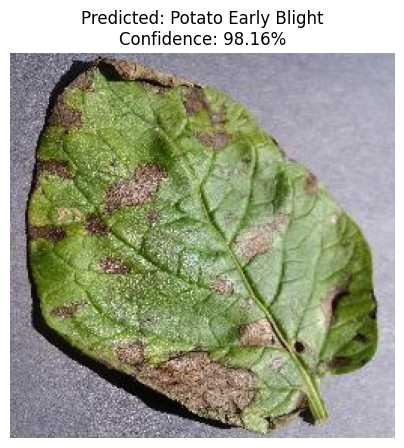


Prediction for: /kaggle/input/new-plant-diseases-dataset/test/test/PotatoEarlyBlight1.JPG
  Predicted Class: Potato Early Blight
  Confidence: 98.16%

Top 5 predictions:
  Potato Early Blight: 98.16%
  Potato Late Blight: 1.83%
  Tomato Late Blight: 0.01%
  Tomato Septoria Leaf Spot: 0.00%
  Tomato Early Blight: 0.00%

--- Batch Prediction Example ---

Processed 10 images:
  train_Potato leaf late blight_11_35.jpg: Potato Late Blight (85.33%)
  train_Potato leaf late blight_80_4_161_aug0.jpg: Potato Late Blight (64.62%)
  train_Tomato two spotted spider mites leaf_1_1676.jpg: Tomato Spider Mites (40.12%)
  droppedImage_3-1_jpg.rf.e4242ab2a7574b9d02bd49e238c0e333_78.jpg: Tomato Early Blight (91.36%)
  train_Tomato Early blight leaf_46_2420_aug2.jpg: Tomato Early Blight (99.11%)
  train_Tomato mold leaf_60_1143.jpg: Tomato Leaf Mold (94.79%)
  train_Tomato mold leaf_64_1118.jpg: Tomato Leaf Mold (93.78%)
  train_Tomato leaf yellow virus_40_3_2663.jpg: Tomato Yellow Leaf Curl Virus (99.1

In [16]:
# ============================================================================
# Example Usage
# ============================================================================
if __name__ == "__main__":
    # Paths
    checkpoint_path = "/kaggle/working/best_dinov3_model.pth"
    class_mapping_path = "/kaggle/working/class_mapping.json"  # Optional if embedded in checkpoint
    
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")
    
    # Check if model exists
    if not Path(checkpoint_path).exists():
        print("=" * 80)
        print("ERROR: Model checkpoint not found!")
        print("=" * 80)
        print(f"\nLooked for: {checkpoint_path}")
        print("\nPlease train the model first using the training script.")
        print("After training, you'll find the model checkpoint at:")
        print("  /kaggle/working/best_dinov3_model.pth")
        print("\nTo train the model, run the DINOv3 Fine-tuning Pipeline script.")
        exit(1)
    
    # Load model
    model, processor, class_mapping = load_trained_model(
        checkpoint_path,
        class_mapping_path,
        device
    )
    
    print("\n" + "="*80)
    print("Model Ready for Inference!")
    print("="*80)
    
    # Example 1: Single image prediction
    print("\n--- Single Image Prediction Example ---")
    # Replace with your test image path
    test_image = "/kaggle/input/new-plant-diseases-dataset/test/test/PotatoEarlyBlight1.JPG"
    
    if Path(test_image).exists():
        predicted_class, confidence, all_probs = predict_single_image(
            test_image, model, processor, class_mapping, device
        )
        
        print(f"\nPrediction for: {test_image}")
        print(f"  Predicted Class: {predicted_class}")
        print(f"  Confidence: {confidence*100:.2f}%")
        print(f"\nTop 5 predictions:")
        sorted_probs = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)[:5]
        for class_name, prob in sorted_probs:
            print(f"  {class_name}: {prob*100:.2f}%")
    
    # Example 2: Batch prediction
    print("\n--- Batch Prediction Example ---")
    test_dir = Path("/kaggle/working/split_dataset/test")
    
    if test_dir.exists():
        # Get first 10 test images
        test_images = []
        for class_dir in test_dir.iterdir():
            if class_dir.is_dir():
                test_images.extend(list(class_dir.glob("*.jpg"))[:2])
        
        if test_images:
            results = predict_batch(
                [str(p) for p in test_images[:10]], 
                model, processor, class_mapping, device
            )
            
            print(f"\nProcessed {len(results)} images:")
            for result in results:
                print(f"  {Path(result['image_path']).name}: "
                      f"{result['predicted_class']} ({result['confidence']*100:.2f}%)")
    
    # Example 3: Save class mapping reference
    print("\n--- Class Mapping Reference ---")
    print("You can use this mapping in any downstream application:")
    print(json.dumps(class_mapping, indent=2))

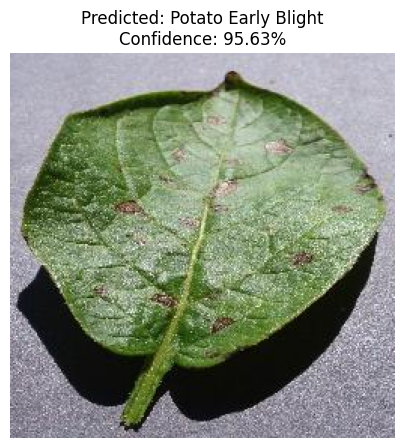


Prediction for: /kaggle/input/new-plant-diseases-dataset/test/test/PotatoEarlyBlight5.JPG
  Predicted Class: Potato Early Blight
  Confidence: 95.63%

Top 5 predictions:
  Potato Early Blight: 95.63%
  Potato Late Blight: 4.28%
  Potato Healthy: 0.03%
  Tomato Early Blight: 0.02%
  Tomato Target Spot: 0.01%


In [17]:
test_image = "/kaggle/input/new-plant-diseases-dataset/test/test/PotatoEarlyBlight5.JPG"
    
if Path(test_image).exists():
    predicted_class, confidence, all_probs = predict_single_image(
            test_image, model, processor, class_mapping, device
        )
        
    print(f"\nPrediction for: {test_image}")
    print(f"  Predicted Class: {predicted_class}")
    print(f"  Confidence: {confidence*100:.2f}%")
    print(f"\nTop 5 predictions:")
    sorted_probs = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)[:5]
    for class_name, prob in sorted_probs:
        print(f"  {class_name}: {prob*100:.2f}%")
    

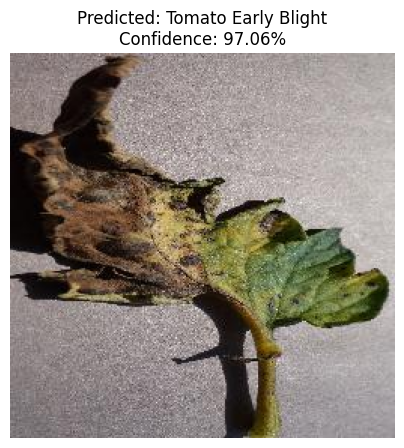

In [18]:
# Single image
pred_class, conf, probs = predict_single_image("/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight1.JPG", model, processor, class_mapping)